# Road traffic data from Norway and Finland

The purpose of this notebook is to get the road traffic data produced by road sensors in Norway and Finland to generate an Origin-Destination (O-D) matrix of the nordic countries. The authorities in Finland and Norway have placed sensors over its territories, to produce the O-D matrix we are going to use the sensors placed on the border of the countries. The sensors on the border of Norway will give the entries between Norway-Sweden, Norway-Finland and Norway-Russia. On the other hand, the sensors on the border of Finland will give the entries between Finland-Sweden and Finland-Russia.

This notebook is divided as follows:
1. Get maps for Finland, Norway, Sweden and Russia
2. Get the metadata for the sensors in Norway
3. Get the sensor data in Norway
4. Get the metadata for the sensors in Finland
5. Get the sensor data in Finland
6. Merge and aggregate the data to produce the O-D matrix
7. Final visualization of the position of the sensors in a map
8. (Appendix) Sensors in Sweden

In [1]:
import os
import geopandas as gpd
import pandas as pd
import requests
import json
import zipfile
import datetime
import time
from io import StringIO
import matplotlib.pyplot as plt
from shapely.geometry import shape

Below is the definition of the global variables.

- `maps_dir_name`: Folder to save the downloaded maps of the countries
- `out_dir_name`: Folder to save the sensor data
- `from_date`: Initial date to get the data from the sensors
- `to_date`: Final date to get the data from the sensors

Probably the most important of these variables are `from_date` and `to_date`. The notebook will get the data from Norway and Finland between these two dates.

In [22]:
maps_dir_name = 'map_data'
out_dir_name = 'out'
os.makedirs(maps_dir_name, exist_ok=True)
os.makedirs(out_dir_name, exist_ok=True)

from_date = '2019-01-01'
to_date = '2021-12-01'

## 1. Get maps for Finland, Norway, Sweden and Russia

### 1.1 Download the map for Norway

Download the map of Norway divided by *fykjer*. [Source](https://ws.geonorge.no/kommuneinfo/v1/#/)

This only needs to be done once since the map will be saved.

In [3]:
maps_nor_base = 'https://ws.geonorge.no/kommuneinfo/v1'
fylker_url = '%s/fylker' % (maps_nor_base, )
r = requests.get(fylker_url, allow_redirects=True)
all_fylkes = r.json()

fylke_ids = []
fylke_names = []
fylke_coords = []
for fylke in all_fylkes:
    fylke_id = fylke['fylkesnummer']
    fylke_name = fylke['fylkesnavn']
    fylke_ids.append(fylke_id)
    fylke_names.append(fylke_name)
    
    fylke_coord_url = '%s/fylker/%s/omrade' % (maps_nor_base, fylke_id)
    r = requests.get(fylke_coord_url, allow_redirects=True)
    fylke_resp_coords = r.json()
    
    fylke_shape = shape(fylke_resp_coords['omrade'])
    fylke_coords.append(fylke_shape)
    crs_name = fylke_resp_coords['omrade']['crs']['properties']['name']
    print('Finished getting fylke: %s' % (fylke_name, ))

print('Coordinate standard: %s' % (crs_name, ))
fylke_dic = {
    'fylke_id': fylke_ids,
    'fylke_name': fylke_names,
    'geometry': fylke_coords
}
df = pd.DataFrame(fylke_dic)
nor_fylke = gpd.GeoDataFrame(df, crs=crs_name)

download_nor = os.path.join(maps_dir_name, 'norway_fylker.geojson')
nor_fylke.to_file(download_nor, driver="GeoJSON")

Finished getting fylke: Oslo
Finished getting fylke: Rogaland
Finished getting fylke: Møre og Romsdal
Finished getting fylke: Nordland
Finished getting fylke: Viken
Finished getting fylke: Innlandet
Finished getting fylke: Vestfold og Telemark
Finished getting fylke: Agder
Finished getting fylke: Vestland
Finished getting fylke: Trøndelag
Finished getting fylke: Troms og Finnmark
Coordinate standard: EPSG:4258


/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/PanNordic/pan_env/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


Read the downloaded map of Norway

In [4]:
nor_map_path = os.path.join(maps_dir_name, 'norway_fylker.geojson')
nor_map = gpd.read_file(nor_map_path)

### 1.2 Download the map for Sweden, Russia and Denmark. 

The maps from these three countries are downloaded from the same source, i.e. we can use the same code to download all of them. [Source](https://gadm.org/maps.html)

As with the map of Norway this only needs to be done once since the maps will be saved.

In [5]:
def download_map(country_code):
    template_GADM_URL = 'https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_[x]_shp.zip'
    url = template_GADM_URL.replace('[x]', country_code)
    r = requests.get(url, allow_redirects=True)

    os.makedirs(maps_dir_name, exist_ok=True)

    download_filename = os.path.join(maps_dir_name, url.split('/')[-1])
    with open(download_filename, 'wb') as f:
        f.write(r.content)
    print('Map downloaded: %s' % (download_filename, ))
    
    directory_to_extract_to = os.path.join(maps_dir_name, 'shapefiles')
    with zipfile.ZipFile(download_filename, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)

In [6]:
download_map('SWE')

Map downloaded: map_data/gadm36_SWE_shp.zip


In [7]:
download_map('DNK')

Map downloaded: map_data/gadm36_DNK_shp.zip


In [8]:
download_map('RUS')

Map downloaded: map_data/gadm36_RUS_shp.zip


Load the maps of Sweden, Russia and Denmark

In [9]:
 def load_map(country_code, level):
    map_name_level = 'gadm36_%s_%s.shp' % (country_code, level)
    map_path = os.path.join(maps_dir_name, 'shapefiles', map_name_level)
    gdf = gpd.read_file(map_path)
    
    return gdf

In [10]:
swe_map = load_map('SWE', 1)
rus_map = load_map('RUS', 0)
dnk_map = load_map('DNK', 0)

### 1.3 Load the map of Finland

The map of Finland was pre-downloaded. The map divides Finland in Hospital Care Districts (HCDs). This is the level in which Finland reports the incidence of new coronavirus cases.

In [11]:
finland_map_path = os.path.join(maps_dir_name, 'finland_hcds.geojson')
fin_hcds_map = gpd.read_file(finland_map_path)

## 2. Get the metadata for the sensors in Norway

As mentioned before, Norway has traffic sensors in all of its territory and not just the border. The information and basic metadata of the sensors located on the border can be found in the file `traffic_nor.csv`. This file was hand made by checking the page of the traffic authority in Norway, [vegvesen](https://www.vegvesen.no/trafikkdata/start/kart?lat=64.85003449662187&lon=19.157035747455456&trafikanttype=vehicle&trpids=49453V930259&zoom=3)

First we will get the hand made CSV and then compile the rest of the metadata from the API.

In [12]:
nor_traffic_file = 'traffic_nor.csv'
nor_traffic = pd.read_csv(nor_traffic_file)

Get the information from all the sensors in the API. [Vegvesen API](https://www.vegvesen.no/trafikkdata/start/om-api)

In [13]:
url_traffic_nor = 'https://www.vegvesen.no/trafikkdata/api/'

In [14]:
grap_ql_body = """
{
  trafficRegistrationPoints {
    id
    name
    direction {
      from
      to
    }
    location {
      coordinates {
        latLon {
          lat
          lon
        }
      }
    }
  }
}
"""
payload = {
    'query': grap_ql_body
}
headers = {
    'Content-Type': 'application/json'
}
r = requests.post(url_traffic_nor, json=payload, headers=headers, allow_redirects=True)
all_nor_sensors = r.json()
all_nor_sensors = all_nor_sensors['data']['trafficRegistrationPoints']
print('Number of sensors in API: %s' % (len(all_nor_sensors), ))

Number of sensors in API: 4226


Filter the information of the sensors to only have the sensors in the borders. Group together all the information in a Geopandas Dataframe

In [15]:
nor_border_sensors_ids = list(nor_traffic['id'].values)
nor_border_sensors_outs = list(nor_traffic['in'].values)
nor_border_sensors_ins = list(nor_traffic['out'].values)

nor_sensors_id = []
nor_sensors_name = []
nor_sensors_lat = []
nor_sensors_lon = []
for sensor in all_nor_sensors:
    if sensor['id'] in nor_border_sensors_ids:
        sensor_idx = nor_border_sensors_ids.index(sensor['id'])
        nor_sensors_id.append(sensor['id'])
        nor_sensors_name.append(sensor['name'])
        nor_sensors_lat.append(sensor['location']['coordinates']['latLon']['lat'])
        nor_sensors_lon.append(sensor['location']['coordinates']['latLon']['lon'])
        
        directions = []
        directions.append(sensor['direction']['from'])
        directions.append(sensor['direction']['to'])
        
        csv_in = nor_border_sensors_outs[sensor_idx]
        if csv_in not in directions:
            raise ValueError('Direction not found: %s. Sensor: %s. Directions: %s' % (csv_in, sensor['id'], directions))
        
        csv_out = nor_border_sensors_outs[sensor_idx]
        if csv_in not in directions:
            raise ValueError('Direction not found: %s. Sensor: %s. Directions: %s' % (csv_out, sensor['id'], directions))

print('%s/%s sensors found.' % (len(nor_sensors_id), len(nor_border_sensors_ids)))
nor_sensors_dic = {
    'id': nor_sensors_id,
    'name': nor_sensors_name,
    'lat': nor_sensors_lat,
    'lon': nor_sensors_lon
}
df = pd.DataFrame(nor_sensors_dic)
nor_sensors_df = gpd.GeoDataFrame(
                    df,
                    geometry=gpd.points_from_xy(df.lon, df.lat)
)

nor_border_sensors_df = pd.merge(
                nor_sensors_df, nor_traffic,
                on=['id'], how='left', suffixes=('', '_DROP')
            )
nor_border_sensors_df = nor_border_sensors_df.filter(regex='^(?!.*_DROP)')
nor_border_sensors_df = nor_border_sensors_df.drop(columns=['country', 'lat', 'lon'], axis=1)

33/33 sensors found.


The following function is a helper function to determine which is the closest country to a sensor. For example, given we know the senor is in Norway determine if its in the border of Russia, Sweden and Finland. Furthermore, since we got the maps of the countries by region, we can determine not only the neighboring country but also the neighboring region.

In [16]:
def min_distance_sensor_border(sensor_coord, check_borders):
    # Auxialiary function to check the distance to a border no matter
    # if the shape is given as Multiplygon or Polygon
    def check_distance(reg_coord, sensor_coords):
        if 'MultiPolygon' == reg_coord.type:
            min_distance = 10000
            for polygon in list(reg_coord.geoms):
                dist = polygon.exterior.distance(sensor_coords)
                if dist < min_distance:
                    min_distance = dist
            dist_sensor_reg = min_distance
        else:
            dist_sensor_reg = reg_coord.exterior.distance(sensor_coords)

        return dist_sensor_reg

    swe_regs = swe_map.values.tolist()
    rus_regs = rus_map.values.tolist()
    dnk_regs = dnk_map.values.tolist()
    fin_hcds = fin_hcds_map.values.tolist()
    nor_fylkes = nor_map.values.tolist()

    closer_dist = 100000000
    closer_reg = None
    closer_reg_id = None
    closer_country = None
    if 'SWE' in check_borders:
        for reg in swe_regs:
            reg_coord = reg[-1]
            dist_sensor_reg = check_distance(reg_coord, sensor_coord)
            if dist_sensor_reg < closer_dist:
                closer_country = 'SWE'
                closer_reg_id = reg[2]
                closer_reg = reg[3]
                closer_dist = dist_sensor_reg

    if 'RUS' in check_borders:
        for reg in rus_regs:
            reg_coord = reg[-1]
            dist_sensor_reg = check_distance(reg_coord, sensor_coord)
            if dist_sensor_reg < closer_dist:
                closer_country = 'RUS'
                closer_reg_id = '0'
                closer_reg = 'RUS'
                closer_dist = dist_sensor_reg

    if 'DNK' in check_borders:
        for reg in dnk_regs:
            reg_coord = reg[-1]
            dist_sensor_reg = check_distance(reg_coord, sensor_coord)
            if dist_sensor_reg < closer_dist:
                closer_country = 'DNK'
                closer_reg_id = reg[2]
                closer_reg = reg[3]
                closer_dist = dist_sensor_reg

    if 'FIN' in check_borders:
        for reg in fin_hcds:
            reg_coord = reg[-1]
            dist_sensor_reg = check_distance(reg_coord, sensor_coord)
            if dist_sensor_reg < closer_dist:
                closer_country = 'FIN'
                closer_reg_id = reg[0]
                closer_reg = reg[3].replace('"', '')
                closer_dist = dist_sensor_reg

    if 'NOR' in check_borders:
        for fylke in nor_fylkes:
            fylke_id, fylke_name, fylke_coord = fylke
            dist_sensor_reg = check_distance(fylke_coord, sensor_coord)
            if dist_sensor_reg < closer_dist:
                closer_country = 'NOR'
                closer_reg_id = fylke_id
                closer_reg = fylke_name
                closer_dist = dist_sensor_reg
    
    return closer_reg, closer_reg_id, closer_country

Parse the response of the API metadata. Determine in which region is the sensor and use the function defined above to determine the neighboring region as well.

In [17]:
# Get the coordinates of the sensors
nor_sensors_coord = nor_border_sensors_df['geometry'].values

# Get the shapes of the regions
nor_fylkes = nor_map.values.tolist()

origin_regs = []
origin_regs_id = []
dest_regs = []
dest_regs_id = []
dest_country = []
# Iterate over the sensor coordinates
for sensor_coord in nor_sensors_coord:
    # Iterate over the regions to determine the region where the sensor is located
    for fylke in nor_fylkes:
        fylke_id, fylke_name, fylke_coord = fylke
        # The region contains the sensor
        if fylke_coord.contains(sensor_coord):
            origin_regs.append(fylke_name)
            origin_regs_id.append(fylke_id)
    
    # Determine the closest country and region
    closer_reg, closer_reg_id, closer_country = min_distance_sensor_border(
                                                    sensor_coord,
                                                    check_borders=['SWE', 'FIN', 'RUS', 'DNK']
                                                )
    dest_regs.append(closer_reg)
    dest_regs_id.append(closer_reg_id)
    dest_country.append(closer_country)

nor_border_sensors_df['origin_reg_name'] = origin_regs
nor_border_sensors_df['origin_reg_id'] = origin_regs_id
nor_border_sensors_df['origin_country'] = 'NOR'
nor_border_sensors_df['dest_reg_name'] = dest_regs
nor_border_sensors_df['dest_reg_id'] = dest_regs_id
nor_border_sensors_df['dest_country'] = dest_country

The resulting complete GeoPandas dataframe can be visualized below

In [46]:
nor_sensors_path = os.path.join(out_dir_name, 'norway_sensors_metadata.geojson')
nor_border_sensors_df.to_file(nor_sensors_path, driver="GeoJSON")
nor_border_sensors_df

,id,name,geometry,in,out,origin_reg_name,origin_reg_id,origin_country,dest_reg_name,dest_reg_id,dest_country
0,04904V971774,NYE SVINESUND BRU,POINT (11.25096 59.09752),Oslo,Sverige,Viken,30,NOR,Västra Götaland,SWE.21_1,SWE
1,51812V1203972,Umbukta,POINT (14.57965 66.19075),Mo i Rana,Umbukta,Nordland,18,NOR,Västerbotten,SWE.18_1,SWE
2,50089V578151,SANDVIKA,POINT (12.25480 63.65010),VERDALSØRA,DUVED,Trøndelag,50,NOR,Jämtland,SWE.6_1,SWE
3,14158V705081,FLERMOBERGET,POINT (12.69807 61.21765),X/RV 25,SVERIGE,Innlandet,34,NOR,Dalarna,SWE.2_1,SWE
4,69140V704643,STØA,POINT (12.81633 61.26021),ØSTBY,SVERIGE,Innlandet,34,NOR,Dalarna,SWE.2_1,SWE
5,00737V704646,LUTNES,POINT (12.59628 61.04765),NYBERGSUND,SVERIGE,Innlandet,34,NOR,Värmland,SWE.17_1,SWE
6,76778V704564,MOROKULIEN,POINT (12.22100 59.93647),KONGSVINGER,SVERIGE,Innlandet,34,NOR,Värmland,SWE.17_1,SWE
7,11051V704737,Drevsjø øst,POINT (12.04433 61.88666),Drevsjø,Riksgrensen,Innlandet,34,NOR,Dalarna,SWE.2_1,SWE
8,08581V885541,Skardmodalen,POINT (14.31618 65.48754),Hattfjelldalen,Sverige,Nordland,18,NOR,Västerbotten,SWE.18_1,SWE
9,68101V930654,Neiden tollsted riksgrense,POINT (29.24207 69.70140),Neiden,Riksgrensen,Troms og Finnmark,54,NOR,Lapin SHP,hcd21,FIN


## 3. Get the sensor data in Norway

The API only allows to get the data sensor by sensor. The following function is in charge of getting the data of a single sensor between the dates `from_day` and `to_day`. Something to note is that the API restricts the size its reponse, i.e. for a sufficiently large time period we would need to make several queries to get the complete data, the data is paged. This function also takes care of that by being recursive and taking the variable `cursor`. This variable is a pointer for the next chunk of data.

In [19]:
def get_sensor_traffic(sensor_id, from_day, to_day, cursor='', print_errors=False):
    grap_ql_body = """
    {{
        trafficData(trafficRegistrationPointId: "{sensor_id}") {{
            volume {{
                byHour(
                    from: "{from_day}T00:00:00+00:00"
                    to: "{to_day}T00:00:00+00:00"
                    {cursor}
                ) {{
                    pageInfo {{
                        endCursor
                        hasNextPage
                    }}
                    edges {{
                        node {{
                            from
                            to
                            byDirection {{
                                heading
                                total {{
                                    volumeNumbers {{
                                        volume
                                    }}
                                    coverage {{
                                        percentage
                                    }}
                                }}
                            }}
                        }}
                    }}
                }}
            }}
        }}
    }}
    """.format(
        sensor_id=sensor_id,
        from_day=from_day,
        to_day=to_day,
        cursor=cursor
    )
    payload = {
        'query': grap_ql_body
    }
    headers = {
        'Content-Type': 'application/json'
    }
    # If we make a lot of requests the API might fail and timeout
    # Try to get the information 3 times before quiting
    it = 0
    r = None
    while it < 3:
        try:
            r = requests.post(url_traffic_nor, json=payload, headers=headers, allow_redirects=True, timeout=10)
        except Exception:
            if print_errors:
                print("TimeoutError: {id}".format(id=sensor_id))

        if r is None:
            print("Waiting for 5 seconds")
            time.sleep(5)
            it += 1
        else:
            if r.status_code == 200:
                break
            elif r.status_code == 404:
                break
            else:
                print(f"Waiting: {r.status_code}")
                time.sleep(5)
                it += 1
    
    if r.status_code != 200:
        raise ValueError('Incorrect response from API:\n%s' % (r.content, ))
    
    sensor_response = r.json()
    if sensor_response['data'] is None:
        raise ValueError('Incorrect response from API:\n%s' % (sensor_response, ))

    has_next_page = sensor_response['data']['trafficData']['volume']['byHour']['pageInfo']['hasNextPage']
    sensor_data = sensor_response['data']['trafficData']['volume']['byHour']['edges']
    lines = []
    for measure in sensor_data:
        from_date = measure['node']['from'].split('T')[0]
        to_date = measure['node']['to'].split('T')[0]
        
        from_hour = measure['node']['from'].split('T')[1]
        to_hour = measure['node']['to'].split('T')[1]
        
        hour = "%s-%s" % (from_hour.split(':')[0], to_hour.split(':')[0])
        
        for direction in  measure['node']['byDirection']:
            dir_name = direction['heading']
            if direction['total']['volumeNumbers'] is None:
                total = 0
                if print_errors:
                    print(
                        'Sensor error: %s.\nDate:%s. Hour: %s\nDirection: %s.' % (
                            sensor_id,
                            from_date,
                            hour,
                            direction
                        )
                    )
            else:
                total = direction['total']['volumeNumbers']['volume']
                
            line = [sensor_id, from_date, hour, dir_name, total]
            lines.append(line)
    
    if has_next_page:
        end_cursor = sensor_response['data']['trafficData']['volume']['byHour']['pageInfo']['endCursor']
        return lines + get_sensor_traffic(
                            sensor_id,
                            from_day,
                            to_day,
                            cursor='after:"{end_cursor}"'.format(end_cursor=end_cursor)
                        )
    else:
        return lines

The following function uses the previous function to get the data from all the sensors and compile it in a single Pandas Dataframe.

In [20]:
def get_border_traffic(border_sensors_df, from_day, to_day):
    sensors_ids = border_sensors_df['id'].values.tolist()
    all_sensors_data = []
    got_sensors = 0
    # Get data sensor by sensor
    # Note: This for could potentially be separated in multiple processes.
    # With a large time-span it could be benefitial
    for sensor in sensors_ids:
        single_sensor_data = get_sensor_traffic(sensor, from_day, to_day)
        all_sensors_data += single_sensor_data
        got_sensors += 1
        print('Got data from %s/%s' % (got_sensors, len(sensors_ids)))
    
    # Construct a pandas DF with the data
    sensor_traffic_df = pd.DataFrame.from_records(
                            all_sensors_data,
                            columns=['sensor_id', 'date', 'hour', 'sensor_dir', 'total_vehicles']
                        )
    
    # Merge the data from the measurements of the sensors with information of the sensors DF
    keys = ['sensor_id', 'sensor_dir']

    origin_df = border_sensors_df.rename(columns={"in": "sensor_dir", "id": 'sensor_id'})
    origin_merged = pd.merge(
                    sensor_traffic_df, origin_df,
                    on=keys, how='left', suffixes=('_DROP', '')
                )
    origin_merged = origin_merged.filter(regex='^(?!.*_DROP)')
    origin_merged = origin_merged.drop(columns=['out', 'geometry', 'name'], axis=1)
    origin_merged = origin_merged.loc[~origin_merged['origin_reg_name'].isnull()]
    origin_merged = origin_merged.rename(columns={
                        "origin_reg_name": "dest_reg_name",
                        "origin_reg_id": "dest_reg_id",
                        "origin_country": "dest_country",
                        "dest_reg_name": "origin_reg_name",
                        "dest_reg_id": "origin_reg_id",
                        "dest_country": "origin_country",
                    })

    dest_df = border_sensors_df.rename(columns={"out": "sensor_dir", "id": 'sensor_id'})
    dest_merged = pd.merge(
                    sensor_traffic_df, dest_df,
                    on=keys, how='left', suffixes=('_DROP', '')
                )
    dest_merged = dest_merged.filter(regex='^(?!.*_DROP)')
    dest_merged = dest_merged.drop(columns=['in', 'geometry', 'name'], axis=1)
    dest_merged = dest_merged.loc[~dest_merged['origin_reg_name'].isnull()]

    sensor_data_full = origin_merged.append(dest_merged)
    # Re-organize the columns
    sensor_data_full = sensor_data_full[['sensor_id', 'sensor_dir', 'date', 'hour',
                                         'origin_country', 'origin_reg_id', 'origin_reg_name',
                                         'dest_country', 'dest_reg_id', 'dest_reg_name', 'total_vehicles']]
    
    # Assert that there was no missing data in the process and return the result
    assert len(sensor_data_full) == len(sensor_traffic_df)
    
    return sensor_data_full

In [23]:
nor_traffic_sensors_df = get_border_traffic(nor_border_sensors_df, from_date, to_date)

Got data from 1/33
Got data from 2/33
Got data from 3/33
Got data from 4/33
Got data from 5/33
Waiting for 5 seconds
Got data from 6/33
Waiting for 5 seconds
Got data from 7/33
Waiting for 5 seconds
Got data from 8/33
Got data from 9/33
Got data from 10/33
Got data from 11/33
Got data from 12/33
Got data from 13/33
Got data from 14/33
Got data from 15/33
Got data from 16/33
Got data from 17/33
Got data from 18/33
Got data from 19/33
Got data from 20/33
Got data from 21/33
Got data from 22/33
Waiting for 5 seconds
Got data from 23/33
Got data from 24/33
Got data from 25/33
Got data from 26/33
Waiting for 5 seconds
Got data from 27/33
Got data from 28/33
Got data from 29/33
Waiting for 5 seconds
Got data from 30/33
Got data from 31/33
Got data from 32/33
Waiting for 5 seconds
Got data from 33/33


This is the final result of the function. Note that each line of the DataFrame has its data, hour of measurement, origin country, region and region ID. Similarly for the destination. This permits that the data can be aggregrated to the national level or keep it at the regional level

In [24]:
nor_traffic_sensors_df

,sensor_id,sensor_dir,date,hour,origin_country,origin_reg_id,origin_reg_name,dest_country,dest_reg_id,dest_reg_name,total_vehicles
0,04904V971774,Oslo,2019-01-01,01-02,SWE,SWE.21_1,Västra Götaland,NOR,30,Viken,15
2,04904V971774,Oslo,2019-01-01,02-03,SWE,SWE.21_1,Västra Götaland,NOR,30,Viken,22
4,04904V971774,Oslo,2019-01-01,03-04,SWE,SWE.21_1,Västra Götaland,NOR,30,Viken,11
6,04904V971774,Oslo,2019-01-01,04-05,SWE,SWE.21_1,Västra Götaland,NOR,30,Viken,10
8,04904V971774,Oslo,2019-01-01,05-06,SWE,SWE.21_1,Västra Götaland,NOR,30,Viken,11
...,...,...,...,...,...,...,...,...,...,...,...
1609124,57929V705247,SVERIGE,2021-11-30,20-21,NOR,34,Innlandet,SWE,SWE.17_1,Värmland,5
1609126,57929V705247,SVERIGE,2021-11-30,21-22,NOR,34,Innlandet,SWE,SWE.17_1,Värmland,3
1609128,57929V705247,SVERIGE,2021-11-30,22-23,NOR,34,Innlandet,SWE,SWE.17_1,Värmland,4
1609130,57929V705247,SVERIGE,2021-11-30,23-00,NOR,34,Innlandet,SWE,SWE.17_1,Värmland,4


Save the complete data as CSV

In [25]:
csv_name = 'norway_traffic_sensors_%s_%s.csv' % (from_date, to_date)
csv_path = os.path.join(out_dir_name, csv_name)
nor_traffic_sensors_df.to_csv(csv_path, index=False)

## 4. Get the metadata for the sensors in Finland

The process followed for Finland is very similar to the one of Norway. First, load a pre hand made CSV file with the basic metadata of the sensors ([digitraffic source](https://liikennetilanne.fintraffic.fi/kartta?lang=fi)) and then compile the rest of the metadata from the [digitraffic API](https://www.digitraffic.fi/en/road-traffic/#restjson--apis).

In [26]:
fin_traffic_file = 'traffic_fin.csv'
fin_traffic = pd.read_csv(fin_traffic_file, delimiter=';')

Compile the information from the API.

In [27]:
url_traffic_fin = 'https://tie.digitraffic.fi/api/v3/metadata'

In [28]:
url_traffic_stations = '%s/tms-stations' % (url_traffic_fin, )
resp = requests.get(url_traffic_stations, allow_redirects=True)
fin_all_sensor_data = resp.json()['features']

In [29]:
fin_border_sensors_ids = fin_traffic['id'].values.tolist()

tms_nums = []
tms_latitude = []
tms_longitude = []
tms_province_codes = []
tmd_dir = []
tms_dir_id = []
for tms in fin_all_sensor_data:
    if tms['properties']['tmsNumber'] in fin_border_sensors_ids:
        tms_nums.append(tms['properties']['tmsNumber'])
        tms_latitude.append(tms['geometry']['coordinates'][1])
        tms_longitude.append(tms['geometry']['coordinates'][0])
        tms_province_codes.append(tms['properties']['provinceCode'])
        tmd_dir.append('1')
        tms_dir_id.append(tms['properties']['direction1MunicipalityCode'])
        
        tms_nums.append(tms['properties']['tmsNumber'])
        tms_latitude.append(tms['geometry']['coordinates'][1])
        tms_longitude.append(tms['geometry']['coordinates'][0])
        tms_province_codes.append(tms['properties']['provinceCode'])
        tmd_dir.append('2')
        tms_dir_id.append(tms['properties']['direction2MunicipalityCode'])
        
        print('Found %s/%s of the FIN border sensors' % (len(tms_nums)/2, len(fin_border_sensors_ids)))

        
df = pd.DataFrame({
        'id': tms_nums,
        'latitude': tms_latitude,
        'longitude': tms_longitude,
        'province': tms_province_codes,
        'dir': tmd_dir,
        'dir_id': tms_dir_id,
    })
fin_sensors_df = gpd.GeoDataFrame(
                    df,
                    geometry=gpd.points_from_xy(df.longitude, df.latitude)
)
fin_border_sensors_df = pd.merge(
                fin_sensors_df, fin_traffic,
                on=['id'], how='left', suffixes=('', '_DROP')
            )
fin_border_sensors_df = fin_border_sensors_df.filter(regex='^(?!.*_DROP)')
fin_border_sensors_df = fin_border_sensors_df.drop(columns=['latitude', 'longitude'], axis=1)

fin_province_file = 'fin_province_info.csv'
fin_province = pd.read_csv(fin_province_file, delimiter=',')

fin_border_sensors_df = fin_border_sensors_df.astype({'province': 'int64', 'dir': 'int64'})
fin_border_sensors_df = pd.merge(
                fin_border_sensors_df, fin_province,
                on=['province'], how='left', suffixes=('', '_DROP')
            )

Found 1.0/19 of the FIN border sensors
Found 2.0/19 of the FIN border sensors
Found 3.0/19 of the FIN border sensors
Found 4.0/19 of the FIN border sensors
Found 5.0/19 of the FIN border sensors
Found 6.0/19 of the FIN border sensors
Found 7.0/19 of the FIN border sensors
Found 8.0/19 of the FIN border sensors
Found 9.0/19 of the FIN border sensors
Found 10.0/19 of the FIN border sensors
Found 11.0/19 of the FIN border sensors
Found 12.0/19 of the FIN border sensors
Found 13.0/19 of the FIN border sensors
Found 14.0/19 of the FIN border sensors
Found 15.0/19 of the FIN border sensors
Found 16.0/19 of the FIN border sensors
Found 17.0/19 of the FIN border sensors
Found 18.0/19 of the FIN border sensors
Found 19.0/19 of the FIN border sensors


Remove the sensors that are in the border of Norway to avoid double counting (counting one time in the sensor of Finland and another time in the sensor of Norway).

In [30]:
fin_border_sensors_df = fin_border_sensors_df.loc[fin_border_sensors_df['out_id'] != 1020]

Also similar to Norway, parse the response of the API metadata. Determine in which region is the sensor and use the function defined before to determine the neighboring region as well.

In [31]:
# Get the coordinates of the sensors
fin_sensors_coord = fin_border_sensors_df['geometry'].values

fin_hcds = fin_hcds_map.values.tolist()

origin_regs = []
origin_regs_id = []
dest_regs = []
dest_regs_id = []
dest_country = []
# Iterate over the coordinates
for sensor_coord in fin_sensors_coord:
    # Iterate over the regions of Finland to determine if the sensor belongs to this one
    for hcd in fin_hcds:
        hcd_id, _, _, hcd_name, _, hcd_coord = hcd
        # The senor is contained in the region
        if hcd_coord.contains(sensor_coord):
            origin_regs.append(hcd_name.replace('"', ''))
            origin_regs_id.append(hcd_id)
    
    # Determine the closest country and region to the sensor
    closer_reg, closer_reg_id, closer_country = min_distance_sensor_border(
                                                    sensor_coord,
                                                    check_borders=['SWE', 'NOR', 'RUS', 'DNK']
                                                )
    dest_regs.append(closer_reg)
    dest_regs_id.append(closer_reg_id)
    dest_country.append(closer_country)

fin_border_sensors_df['origin_reg_name'] = origin_regs
fin_border_sensors_df['origin_reg_id'] = origin_regs_id
fin_border_sensors_df['origin_country'] = 'FIN'
fin_border_sensors_df['dest_reg_name'] = dest_regs
fin_border_sensors_df['dest_reg_id'] = dest_regs_id
fin_border_sensors_df['dest_country'] = dest_country

Compile the information in a GeoPandas DataFrame. Below we can visualize the final result. Note that there are two entries per sensor in the DF. There is one entry per direction of the sensor.

In [32]:
fin_out_dir = fin_border_sensors_df.loc[
                fin_border_sensors_df['dir_id'] == fin_border_sensors_df['out_id'],
            ]
fin_in_dir = fin_border_sensors_df.loc[
                fin_border_sensors_df['dir_id'] == fin_border_sensors_df['in_id'],
            ]
fin_in_dir = fin_in_dir.rename(columns={
                    "origin_reg_name": "dest_reg_name",
                    "origin_reg_id": "dest_reg_id",
                    "origin_country": "dest_country",
                    "dest_reg_name": "origin_reg_name",
                    "dest_reg_id": "origin_reg_id",
                    "dest_country": "origin_country",
                })
fin_border_sensors_dir_df = fin_out_dir.append(fin_in_dir)
fin_border_sensors_dir_df

,id,province,dir,dir_id,geometry,name,in,in_id,out,out_id,ely-center,origin_reg_name,origin_reg_id,origin_country,dest_reg_name,dest_reg_id,dest_country
0,306,9,1,1002,POINT (28.52023 60.95499),Tie 13 Nuijamaa,Lappeenranta,405,Russia,1002,3,Etelä-Karjalan SHP,hcd09,FIN,RUS,0,RUS
2,532,9,1,1006,POINT (28.83362 61.12761),Tie 62 Imatra raja 2,Imatra,153,Venäjä,1006,3,Etelä-Karjalan SHP,hcd09,FIN,RUS,0,RUS
4,598,8,1,1006,POINT (27.86907 60.60645),"Tie 7 Virolahti, Vaalimaa, raskas, Vaalimaa",Hamina,75,Venäjä,1006,3,Kymenlaakson SHP,hcd08,FIN,RUS,0,RUS
6,724,12,1,1006,POINT (30.62246 62.17168),"Tie 9 Tohmajärvi, Niirala",Suomi,1011,Venäjä,1006,8,Pohjois-Karjalan SHP,hcd12,FIN,RUS,0,RUS
8,1252,17,1,1006,POINT (30.09282 65.80008),Tie 866 Kuusamo,Kuusamo,305,Venäjä,1006,12,Pohjois-Pohjanmaan SHP,hcd18,FIN,RUS,0,RUS
10,1325,18,1,1006,POINT (29.90888 64.49625),Tie 89 Vartius,Kajaani,205,Venäjä,1006,12,Kainuun SHP,hcd19,FIN,RUS,0,RUS
12,1429,19,1,1006,POINT (28.47253 68.47601),"Tie 91 Inari, Rajajooseppi",Inari,148,Venäjä,1006,14,Lapin SHP,hcd21,FIN,RUS,0,RUS
14,1430,19,1,1006,POINT (29.03317 66.94372),"Tie 82 Salla, Kelloselkä",Salla,732,Venäjä,1006,14,Lapin SHP,hcd21,FIN,RUS,0,RUS
16,1431,19,1,1010,POINT (24.14617 65.84133),Tie 9211 Tornio,Suomi,1011,Ruotsi,1010,14,Länsi-Pohjan SHP,hcd20,FIN,Norrbotten,SWE.10_1,SWE
18,1432,19,1,1010,POINT (23.68838 66.37887),Tie 98 Aavasaksa,Suomi,1011,Ruotsi,1010,14,Länsi-Pohjan SHP,hcd20,FIN,Norrbotten,SWE.10_1,SWE


Save the resulting DF as GeoJson

In [47]:
fin_sensors_path = os.path.join(out_dir_name, 'finland_sensors_metadata.geojson')
fin_border_sensors_dir_df.to_file(fin_sensors_path, driver="GeoJSON")

## 5. Get the sensor data in Finland

The following fuction gets the data of a single sensor between the dates `from_day` and `to_day`. In this case, the API used is not the same one as the sensors (digitraffic). In this case the data is compiled in the [vayla API](https://aineistot.vayla.fi/lam/rawdata/).

**Note 1:** In the [webpage of vayla](https://vayla.fi/vaylista/aineistot/avoindata) they mention that the historical data of the sensors will be availabe also in the digitraffic webpage in January 2022 but that it will remain also open in the current endpoint. It would be good to check if the change affects this function in the future.

**Note 2:** The function is based in code originally published in [this Github repository](https://github.com/FINCoVID19/fin-traffic-data-fork).

In [33]:
def get_sensor_traffic_fin(sensor_id, ely_id, from_day, to_day, print_errors=False):
    _tms_raw_column_names = [
        'id', 'year', 'day_number', 'hour', 'minute', 'second', 'millisecond',
        'length', 'lane', 'dir', 'vehicle category', 'speed', 'faulty',
        'total time', 'timespan', 'queue_begin'
    ]

    from_date = datetime.datetime.strptime(from_day, "%Y-%m-%d")
    to_date = datetime.datetime.strptime(to_day, "%Y-%m-%d")
    iter_date = from_date
    dfs = []
    while iter_date <= to_date:
        year_date0 = datetime.datetime(year=iter_date.year, day=1, month=1)
        day_number = (iter_date - year_date0).days + 1
        year_short = f"{iter_date:%y}"

        tms_url = 'https://aineistot.vayla.fi/lam/rawdata/{year}/{ely_id}/lamraw_{tms_id}_{year_short}_{day_number}.csv'. format(
                        year=iter_date.year,
                        ely_id=ely_id,
                        tms_id=sensor_id,
                        year_short=year_short,
                        day_number=day_number,
                    )
        it = 0
        resp = None
        # Try to get the information 3 times before quiting
        while it < 3:
            try:
                resp = requests.get(tms_url, allow_redirects=True, timeout=10)
            except Exception:
                if print_errors:
                    print(f"Timeouterror: {date} {tms_id}")

            if resp is None:
                print("Waiting for 5 seconds")
                time.sleep(5)
                it += 1
            else:
                if resp.status_code == 200:
                    break
                elif resp.status_code == 404:
                    break
                else:
                    print(f"Waiting: {resp.status_code}")
                    time.sleep(5)
                    it += 1

        # Parse the response
        if resp.status_code != 200:
            if print_errors:
                print(f"Failed to fetch {iter_date}: {sensor_id}, {resp.status_code}")
        else:
            stream = StringIO(resp.text)
            stream.seek(0)
            df = pd.read_csv(stream,
                             names=_tms_raw_column_names,
                             delimiter=';')
            
            # Remove faulty measurements
            df = df.loc[df['faulty'] == 0]
            dfs.append(df)
        
        iter_date += datetime.timedelta(days=1)
        
    if dfs:
        dfs = pd.concat(dfs)
        dfs['total_vehicles'] = 1
        dfs['year'] = dfs['year'] + 2000
        dfs['day_number'] = dfs['day_number'] - 1
        dfs = dfs.astype({'year': 'int32', 'day_number': 'int32', 'hour': 'int32'})
        dfs['date'] = dfs.apply(
                        lambda row: datetime.datetime(year=int(row['year']), day=1, month=1) + datetime.timedelta(days=row['day_number']),
                        axis=1
                    )
        dfs['hours'] = dfs.apply(
                        lambda row: '%02d-%02d' % (row['hour'], row['hour'] + 1) if row['hour'] < 23 else '23-00',
                        axis=1
                    )
        dfs = dfs.drop(columns=['hour'], axis=1)
        dfs = dfs.rename(columns={"hours": "hour"})
        # Keep the columns in variable selec_cols plus total_vehicles
        selec_cols = ['id', 'dir', 'date', 'hour']
        dfs = dfs[selec_cols + ['total_vehicles']]
        # Count the number of vehicles per hour with groupby
        dfs_time = dfs.groupby(by=selec_cols, as_index=False).sum()
        return dfs_time
    else:
        return None

The following function uses the previous function to compile the data for all the sensors.

In [34]:
def get_border_traffic_fin(border_sensors_df, from_day, to_day):
    sensors_ids = pd.unique(border_sensors_df['id']).tolist()
    elys_ids = []
    for sensor in sensors_ids:
        ely_id = border_sensors_df.loc[border_sensors_df['id'] == sensor, 'ely-center']
        ely_id = ely_id.values[0]
        elys_ids.append(ely_id)
    
    assert len(elys_ids) == len(sensors_ids)
    
    got_sensors = 0
    all_sensors_data = []
    for sensor, ely in zip(sensors_ids, elys_ids):
        single_sensor_df = get_sensor_traffic_fin(sensor, ely, from_day, to_day)
        all_sensors_data.append(single_sensor_df)
        got_sensors += 1
        print('Got data from %s/%s' % (got_sensors, len(sensors_ids)))
    all_sensors_data_df = pd.concat(all_sensors_data)
    
    # Merge the data from the measurements of the sensors with information of the sensors DF
    keys = ['id', 'dir']

    border_measured_data_df = pd.merge(
                    all_sensors_data_df, border_sensors_df,
                    on=keys, how='left', suffixes=('_DROP', '')
                )
    assert len(border_measured_data_df) == len(all_sensors_data_df)
    
    border_measured_data_df = border_measured_data_df.rename(columns={
                                        "id": "sensor_id",
                                        "dir_id": 'sensor_dir'
                                    })
    # Re-organize and select the columns
    sensor_data_full = border_measured_data_df[[
                            'sensor_id', 'sensor_dir', 'date', 'hour',
                            'origin_country', 'origin_reg_id', 'origin_reg_name',
                            'dest_country', 'dest_reg_id', 'dest_reg_name', 'total_vehicles'
                        ]]
    
    return sensor_data_full

In [35]:
fin_traffic_sensors_df = get_border_traffic_fin(fin_border_sensors_dir_df, from_day=from_date, to_day=to_date)

Got data from 1/13
Got data from 2/13
Got data from 3/13
Got data from 4/13
Got data from 5/13
Got data from 6/13
Got data from 7/13
Got data from 8/13
Got data from 9/13
Got data from 10/13
Got data from 11/13
Got data from 12/13
Got data from 13/13


Visualize and save the compiled data for the sensors

In [48]:
csv_name = 'finland_traffic_sensors_%s_%s.csv' % (from_date, to_date)
csv_path = os.path.join(out_dir_name, csv_name)
fin_traffic_sensors_df.to_csv(csv_path, index=False)
fin_traffic_sensors_df

,sensor_id,sensor_dir,date,hour,origin_country,origin_reg_id,origin_reg_name,dest_country,dest_reg_id,dest_reg_name,total_vehicles
0,1252,1006,2019-01-01,07-08,FIN,hcd18,Pohjois-Pohjanmaan SHP,RUS,0,RUS,7
1,1252,1006,2019-01-01,08-09,FIN,hcd18,Pohjois-Pohjanmaan SHP,RUS,0,RUS,1
2,1252,1006,2019-01-01,09-10,FIN,hcd18,Pohjois-Pohjanmaan SHP,RUS,0,RUS,1
3,1252,1006,2019-01-01,10-11,FIN,hcd18,Pohjois-Pohjanmaan SHP,RUS,0,RUS,1
4,1252,1006,2019-01-01,11-12,FIN,hcd18,Pohjois-Pohjanmaan SHP,RUS,0,RUS,3
...,...,...,...,...,...,...,...,...,...,...,...
300632,1436,1011,2021-12-01,19-20,SWE,SWE.10_1,Norrbotten,FIN,hcd21,Lapin SHP,17
300633,1436,1011,2021-12-01,20-21,SWE,SWE.10_1,Norrbotten,FIN,hcd21,Lapin SHP,7
300634,1436,1011,2021-12-01,21-22,SWE,SWE.10_1,Norrbotten,FIN,hcd21,Lapin SHP,3
300635,1436,1011,2021-12-01,22-23,SWE,SWE.10_1,Norrbotten,FIN,hcd21,Lapin SHP,9


## 6. Merge and aggregate the data to produce the O-D matrix

Since the produced DataFrames for Norway and Finland have the same format is easy to concatenat them and then aggregrate them by country.

In [49]:
# Join both DFs
nordic_traffic_sensors_df = fin_traffic_sensors_df.append(nor_traffic_sensors_df)
# Aggregate by country using Pandas
agg_cols = ['date', 'hour', 'origin_country', 'dest_country']
nordic_traffic_sensors_country_df = nordic_traffic_sensors_df.groupby(by=agg_cols, as_index=False).sum()
# Sort by date and hour
nordic_traffic_sensors_country_df = nordic_traffic_sensors_country_df.sort_values(['date', 'hour'])

# Save the resulting aggregation into a CSV
csv_name = 'nordic_traffic_sensors_%s_%s.csv' % (from_date, to_date)
csv_path = os.path.join(out_dir_name, csv_name)
nordic_traffic_sensors_country_df.to_csv(csv_path, index=False)

nordic_traffic_sensors_country_df

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/PanNordic/pan_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  """


,date,hour,origin_country,dest_country,total_vehicles
0,2019-01-01,00-01,FIN,RUS,2
1,2019-01-01,00-01,FIN,SWE,342
2,2019-01-01,00-01,SWE,FIN,303
3,2019-01-01,01-02,FIN,SWE,154
4,2019-01-01,01-02,SWE,FIN,264
...,...,...,...,...,...
91114,2021-12-01,22-23,FIN,SWE,52
91115,2021-12-01,22-23,SWE,FIN,53
91116,2021-12-01,23-00,FIN,RUS,1
91117,2021-12-01,23-00,FIN,SWE,17


## 7. Final visualization of the position of the sensors in a map

Using the metadata information of the sensors and the maps we can visualize the  position of the sensors in a map of the nordic countries. In red the sensors from Norway and in blue from Finland. Note that there are no blue sensors in the border between Finland and Norway since they were removed because all of them match the position of the sensors in Norway.

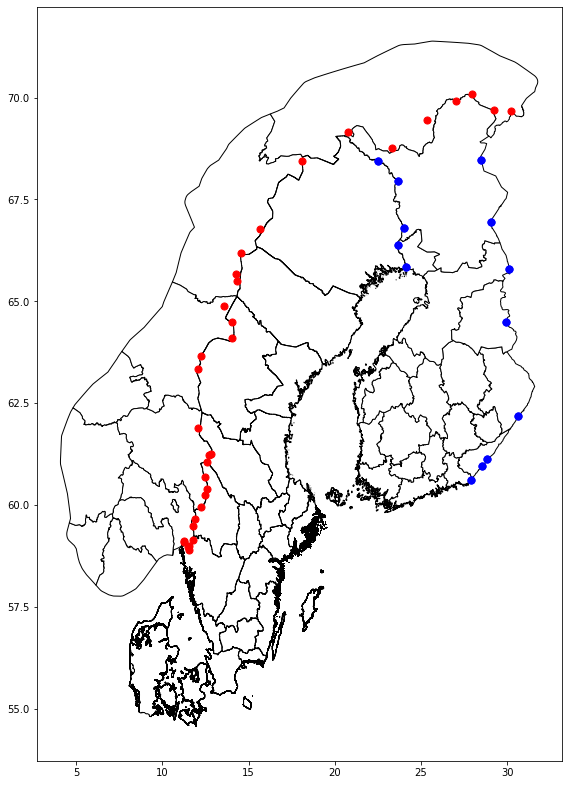

In [40]:
fig, ax = plt.subplots(figsize=(8, 12))

fin_border_sensors_df.plot(ax=ax, marker='o', color='blue', markersize=50, zorder=2)
nor_sensors_df.plot(ax=ax, marker='o', color='red', markersize=50, zorder=2)

nor_fylke.plot(ax=ax, color='white', edgecolor='black', zorder=1)
swe_map.plot(ax=ax, color='white', edgecolor='black', zorder=1)
dnk_map.plot(ax=ax, color='white', edgecolor='black', zorder=1)
fin_hcds_map.plot(ax=ax, color='white', edgecolor='black', zorder=1)
# rus_count.plot(ax=ax, color='white', edgecolor='black')

fig.tight_layout()
plt.show()

## 8. (Appendix) Sensors in Sweden

This last part of the notebook checks the avilable sensors in Sweden and its localization. The information was obtained from the [Trafikverket API](https://api.trafikinfo.trafikverket.se/API). They also confirmed through a [question in the forum](https://api.trafikinfo.trafikverket.se/Forum/Details/61a10b73200b2c070c7da81d) that all of the sensors are located in Stockholm, Goethenburg and Malmö and that they do not provide the historic data through its API.

In [41]:
def get_traffic_sensor():
    url = 'https://api.trafikinfo.trafikverket.se/v2/data.json'
    body = '''
<REQUEST> 
  <LOGIN  authenticationkey = "27c68f188e754291abdbd6c0e19e0051" /> 
  <QUERY  objecttype = "TrafficFlow"  schemaversion = "1" orderby="SiteId"> 
  <FILTER/>
  </QUERY> 
</REQUEST> 
    '''
    headers = {
        'Content-Type': 'application/xml'
    }
    r = requests.post(url, data=body, headers=headers, allow_redirects=True)
    sensor_data = r.json()

    sensor_data = sensor_data['RESPONSE']['RESULT'][0]['TrafficFlow']

    sensors_id = []
    sensors_coord = []
    sensors_county = []
    sensors_region = []
    sensors_lane = []
    sensors_meas_side = []
    regions = set()
    counties = set()
    for sensor in sensor_data:
        sensors_id.append(sensor['SiteId'])
        sensors_coord.append(sensor['Geometry']['WGS84'])
        sensors_county.append(sensor['CountyNo'][0])
        sensors_region.append(sensor['RegionId'])
        sensors_lane.append(sensor['SpecificLane'])
        sensors_meas_side.append(sensor['MeasurementSide'])
        
        regions.add(sensor['RegionId'])
        counties.add(sensor['CountyNo'][0])
        
    print('Num sensors: %s' % (len(sensors_id), ))
    print('Num regions: %s' % (len(regions), ))
    print('Num counties: %s' % (len(counties), ))
    sensor_dic = {
        'sensor_id': sensors_id,
        'wkt': sensors_coord,
        'county': sensors_county,
        'region': sensors_region,
        'lane': sensors_lane,
        'measurement_side': sensors_meas_side,
    }
    df = pd.DataFrame(sensor_dic)
    gs = gpd.GeoSeries.from_wkt(df['wkt'])
    sensor_loc_map = gpd.GeoDataFrame(df, geometry=gs, crs="EPSG:4326")
    sensor_loc_map = sensor_loc_map.drop(columns=['wkt'], axis=1)

    
    return sensor_loc_map, sensor_data

In [42]:
sensors_sweden_loc, sensor_data = get_traffic_sensor()

Num sensors: 3639
Num regions: 3
Num counties: 4


Visalizing the position of the sensors

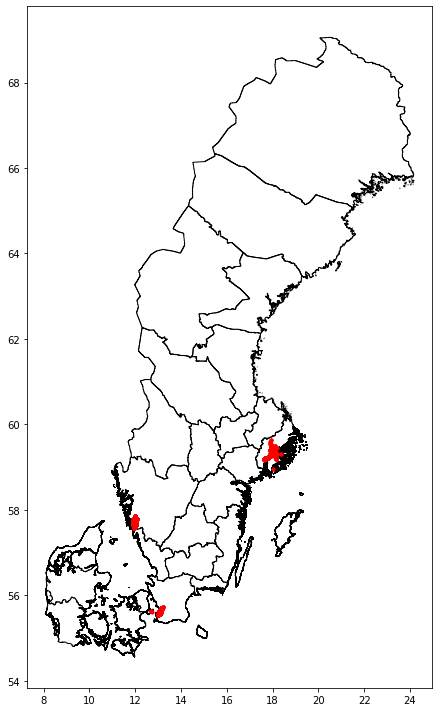

In [43]:
map_swe = load_map('SWE', 1)
map_den = load_map('DNK', 1)

fig, ax = plt.subplots(figsize=(12, 10))

ax.set_aspect('equal')
map_swe.plot(ax=ax, color='white', edgecolor='black')
map_den.plot(ax=ax, color='white', edgecolor='black')
sensors_sweden_loc.plot(ax=ax, marker='o', color='red', markersize=8)

if not True:
    for x, y, label, lane in zip(
                                sensors_sweden_loc.geometry.x,
                                sensors_sweden_loc.geometry.y,
                                sensors_sweden_loc.sensor_id,
                                sensors_sweden_loc.lane
                            ):
        if lane == 'lane1':
            ax.annotate(label, xy=(x, y), xytext=(5, 5), textcoords="offset points")
        elif lane == 'lane2':
            ax.annotate(label, xy=(x, y), xytext=(-5, -5), textcoords="offset points")
        elif lane == 'lane3':
            ax.annotate(label, xy=(x, y), xytext=(5, -5), textcoords="offset points")
        else:
            ax.annotate(label, xy=(x, y), xytext=(-5, 5), textcoords="offset points")


fig.tight_layout()
plt.show()

These are the sensors located in the border of Denmark

In [44]:
sensors_sweden_loc.loc[
    (sensors_sweden_loc['sensor_id'] >= 40000) & (sensors_sweden_loc['sensor_id'] <= 40010), 
]

,sensor_id,county,region,lane,measurement_side,geometry
2679,40004,100,6,lane2,eastBound,POINT (12.67484 55.63200)
2680,40005,100,6,lane1,eastBound,POINT (12.67484 55.63200)
2681,40006,100,6,lane2,westBound,POINT (12.67494 55.63210)
2682,40007,100,6,lane1,westBound,POINT (12.67494 55.63210)


These sensors might also being useful since they are located in the same county as the previous ones

In [45]:
sensors_sweden_loc.loc[
    sensors_sweden_loc['county'] == 100, 
]

,sensor_id,county,region,lane,measurement_side,geometry
2679,40004,100,6,lane2,eastBound,POINT (12.67484 55.63200)
2680,40005,100,6,lane1,eastBound,POINT (12.67484 55.63200)
2681,40006,100,6,lane2,westBound,POINT (12.67494 55.63210)
2682,40007,100,6,lane1,westBound,POINT (12.67494 55.63210)
2683,40064,100,6,lane2,westBound,POINT (12.72970 55.60987)
2684,40065,100,6,lane1,westBound,POINT (12.72970 55.60987)
2685,40066,100,6,lane2,eastBound,POINT (12.67722 55.63115)
2686,40067,100,6,lane1,eastBound,POINT (12.67722 55.63115)
